## Plot belief cross entropies

In [1]:
import json
import sys
import networkx
import pandas
import numpy

from scipy.spatial import distance
from scipy.stats import entropy
import matplotlib.pyplot as plotter
from pathlib import Path
from IPython.display import display, HTML
from sklearn.metrics import log_loss

In [2]:
RATIONAL_ATT_MEANS = None
RATIONAL_ATT_STD = None

FAE_ATT_MEANS = None
FAE_ATT_STD = None

FAE_WITH_CB_MEANS = None
FAE_WITH_CB_STD = None

STATE_MEANS = None
STATE_STD = None

def entropy_with_eps(x, y, **kwargs):
    # print(f"x is {x}")
    # print(f"x with eps is {x + 1e-16}")
    return entropy(x + 1e-16, y + 1e-16, axis=kwargs["axis"])

# metric = lambda x, y: log_loss(y, x)
# metric = distance.jensenshannon
metric = entropy_with_eps

In [3]:
# Pasted verbatim from the results_summarizer

# Common utility function for reading JSON from a file
def load_json(fname):

    data = None

    with open(fname) as f:
        data = json.load(f)

    return data


def get_trace_files(file_list):
    return list(filter(lambda x: "trace" in x.parts[-1], file_list))


# Get belief over opponent frames
def get_opponent_frame(dataframe):
    
    thetaj_columns = list(filter(lambda x: "thetaj" in x.split("."), dataframe))
    
    if len(thetaj_columns) > 0:
        return dataframe[thetaj_columns]
    
    else:
        return None

# Print and plot P(Theta_j)
def print_thetaj_belief(belief_thetaj_df, obs):
    df = pandas.concat([belief_thetaj_df, obs], axis=1)
    display(df)
    df.plot(linewidth=0.5)
    plotter.ylim(-0.1, 1.1)
    plotter.show()

# Summarize beliefs
def summarize_beliefs(state_vars, dataframe):
    print(f"+++++++++++++++++++ Begin Interaction +++++++++++++++++++")
    agent_i_data = filter_columns_by_agent(dataframe, "agent_i")
    agent_j_data = filter_columns_by_agent(dataframe, "agent_j")
    states = filter_columns_by_agent(dataframe, "state")
    
    actions_i = filter_columns_by_state(agent_i_data, "action")
    actions_j = filter_columns_by_state(agent_j_data, "action")
    
    obs_i = filter_columns_by_state(agent_i_data, "observation")
    obs_j = filter_columns_by_state(agent_j_data, "observation")
    
    i_belief_thetaj = get_opponent_frame(agent_i_data)
    if i_belief_thetaj is not None:
        print_thetaj_belief(i_belief_thetaj, obs_i)
    
    j_belief_thetaj = get_opponent_frame(agent_j_data)
    if j_belief_thetaj is not None:
        print_thetaj_belief(j_belief_thetaj, obs_j)
    
    for var in state_vars:
        print(f"============={var}============")
        # show state
        state_values = filter_columns_by_state(states, var)
        state_values = pandas.concat([state_values, actions_i, actions_j], axis = 1)
        display(state_values)
        state_values.plot(linewidth=0.5)
        plotter.ylim(-0.1, 1.1)
        plotter.show()
        
        # show agent i
        agent_i_beliefs = filter_columns_by_state(agent_i_data, var)
        agent_i_beliefs = pandas.concat([agent_i_beliefs, actions_i, actions_j, obs_i], axis = 1)
        display(agent_i_beliefs)
        agent_i_beliefs.plot(linewidth=0.5)
        plotter.ylim(-0.1, 1.1)
        plotter.show()
        
        # show agent j
        agent_j_beliefs = filter_columns_by_state(agent_j_data, var)
        agent_j_beliefs = pandas.concat([agent_j_beliefs, actions_j, actions_i, obs_j], axis = 1)
        display(agent_j_beliefs)
        agent_j_beliefs.plot(linewidth=0.5)
        plotter.ylim(-0.1, 1.1)
        plotter.show()
        print("==============================")
    
    print(f"+++++++++++++++++++ End Interaction +++++++++++++++++++")

# Use state data to figure out the state variables
def get_state_vars(columns):
    
    states = filter(lambda x: "state" in x.split(".") and len(x.split(".")) >= 2, columns)
    state_vars = map(lambda x: x.split(".")[1], states)
    
    return list(set(state_vars))

# Fetch dataframe with columns belonging to a particular agent
def filter_columns_by_agent(dataframe, name):
    columns = dataframe.columns
    filtered_columns = list(filter(lambda x: name in x.split("."), columns))
    
    df = dataframe[filtered_columns]
    return df

# Get columns containing the state name in the header
def filter_columns_by_state(dataframe, state):
    filtered_columns = list(filter(lambda x: state in x.split("."), dataframe.columns))
    return dataframe[filtered_columns]
    

# Get divergence
def print_divergence():
    divs = []
    
    for trace in TRACE_FILES:
        data = load_json(trace)
    
        dataframe = pandas.json_normalize(data)    
        state_vars = get_state_vars(dataframe.columns)
        
        agent_i_data = filter_columns_by_agent(dataframe, "agent_i")
        agent_j_data = filter_columns_by_agent(dataframe, "agent_j")

    for i in range(len(keys)):
        print(f"Plotting for {keys[i]}")

        i_means = numpy.mean(divs[i][0], axis=0)
        i_dev = numpy.std(divs[i][0], axis=0)
        plotter.errorbar(numpy.linspace(1, i_means.shape[0], i_means.shape[0]), i_means, fmt='r-.', yerr=i_dev, linewidth=0.5)

        if len(divs[i]) > 1:
            j_means = numpy.mean(divs[i][1], axis=0)
            j_dev = numpy.std(divs[i][1], axis=0)
            plotter.errorbar(numpy.linspace(1, j_means.shape[0], j_means.shape[0]), j_means, fmt='b-.', yerr=j_dev, linewidth=0.5)
            # plotter.plot(divs[i][1].T, 'b-.', linewidth=0.5)

        plotter.ylim(-0.1, 2)
        plotter.show()

In [4]:
# Trying to plot state cross entropies

def _append_to_dict(_dict, name, matrix):
    
    if name in _dict.keys():
        data = _dict[name]
        data.append(matrix)
        
        _dict[name] = data
        
    else:
        _dict[name] = [matrix]
        

def get_cross_entropies(stat_dict, agent_i_dict, agent_j_dict):
    
    data_dict = dict()
    
    for state in state_dict.keys():
        state_matrix = numpy.array(state_dict[state])
        agent_i_matrix = numpy.array(agent_i_dict[state])
        agent_j_matrix = numpy.array(agent_j_dict[state])
        
        agent_i_diff = metric(agent_i_matrix, state_matrix, axis = 2)
        agent_j_diff = metric(agent_j_matrix, state_matrix, axis = 2)
        
        data_dict[state] = (agent_i_diff, agent_j_diff)
        
    return data_dict


def get_frame_data(files):
    
    agent_i_matrix = []
    agent_j_matrix = []
    
    agent_i_labels = None
    agent_j_labels = None
    
    for _file in files:
        # print(f"[*] Processing {_file}")
        data = load_json(_file)
        df = pandas.json_normalize(data)
        
        agent_i_data = filter_columns_by_agent(df, "agent_i")
        agent_j_data = filter_columns_by_agent(df, "agent_j")
        
        agent_i_theta = get_opponent_frame(agent_i_data)
        agent_j_theta = get_opponent_frame(agent_j_data)
        
        if agent_i_labels is None:
            agent_i_labels = list(map(lambda x: x.split(".")[-1], agent_i_theta.columns))
            
        if agent_j_labels is None:
            agent_j_labels = list(map(lambda x: x.split(".")[-1], agent_j_theta.columns))
        
        # print(agent_i_theta.to_numpy().shape)
        # print(agent_j_theta.to_numpy().shape)
        
        agent_i_matrix.append(agent_i_theta.to_numpy())
        agent_j_matrix.append(agent_j_theta.to_numpy())

    return ((agent_i_labels, numpy.array(agent_i_matrix)), (agent_j_labels, numpy.array(agent_j_matrix)))


def get_belief_data(files):
    
    state_dict = dict()
    agent_i_dict = dict()
    agent_j_dict = dict()
    
    for _file in files:
        # print(f"[*] Processing {_file}")
        data = load_json(_file)
        df = pandas.json_normalize(data)
        
        states = get_state_vars(df.columns)
        # print(f"[*] DF has columns {states}")
        
        agent_i_data = filter_columns_by_agent(df, "agent_i")
        agent_j_data = filter_columns_by_agent(df, "agent_j")
        state_data = filter_columns_by_agent(df, "state")
        
        if (agent_i_data is None):
            print("[X] Could not pull data from agent_i")
            
        if (agent_j_data is None):
            print("[X] Could not pull data from agent_j")
            
        for state in states:
            df_state_true = filter_columns_by_state(state_data, state)
            agent_i_state = filter_columns_by_state(agent_i_data, state)
            agent_j_state = filter_columns_by_state(agent_j_data, state)
            
            df_state_true = df_state_true.to_numpy()
            agent_i_state = agent_i_state.to_numpy()
            agent_j_state = agent_j_state.to_numpy()
            
            _append_to_dict(state_dict, state, df_state_true)
            _append_to_dict(agent_i_dict, state, agent_i_state)
            _append_to_dict(agent_j_dict, state, agent_j_state)
            
    return (state_dict, agent_i_dict, agent_j_dict)



## For control data

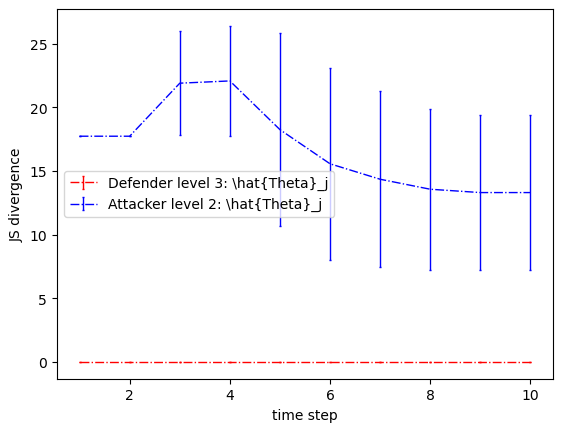

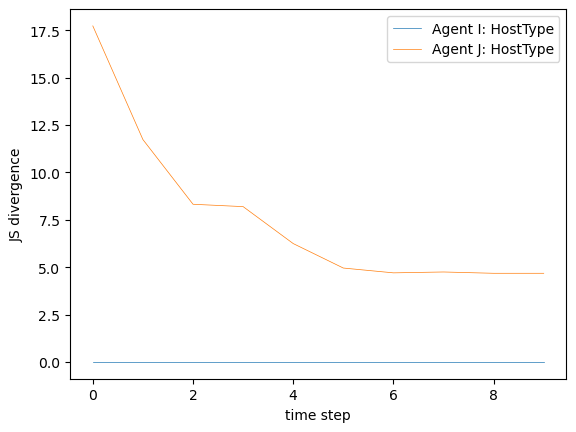

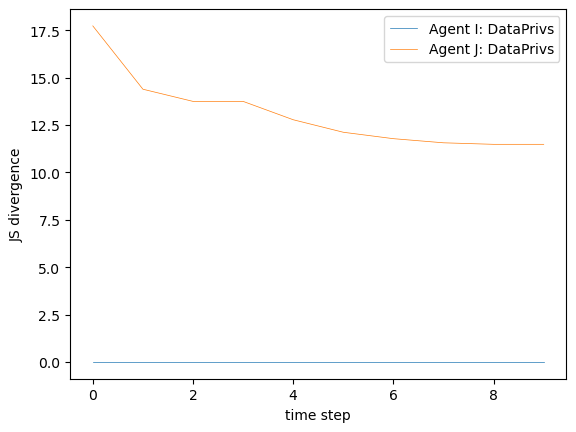

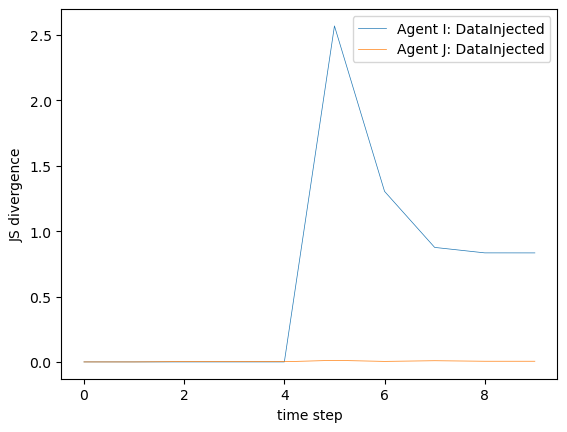

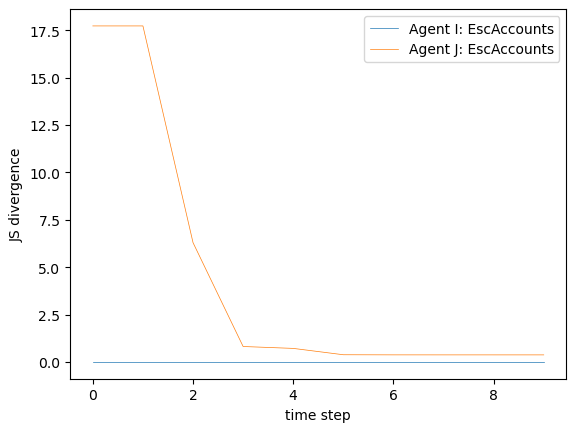

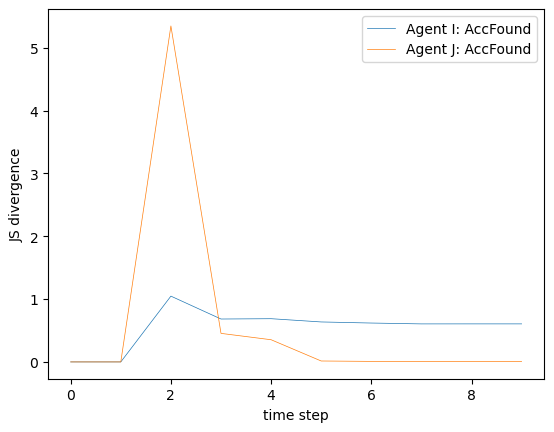

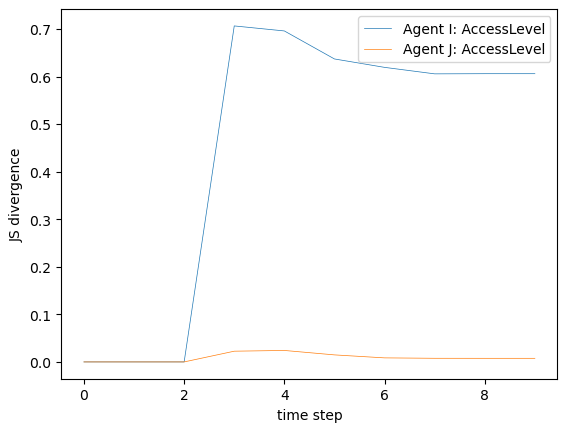

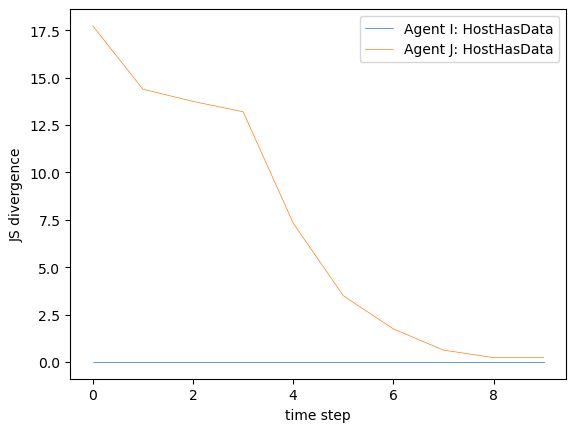

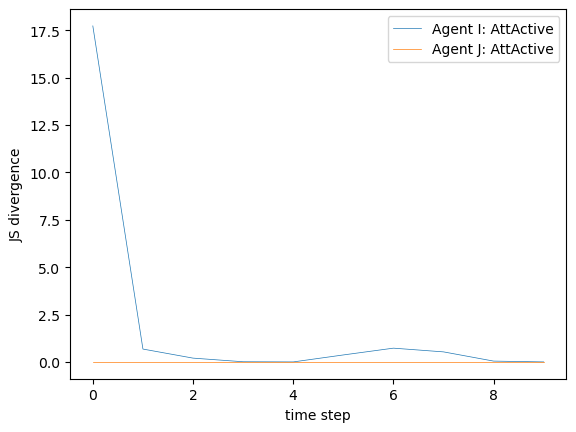

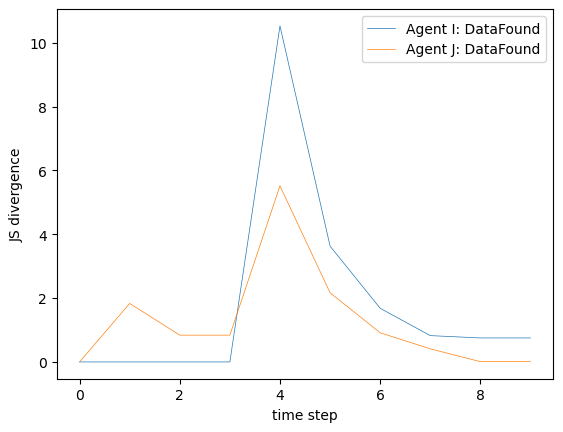

In [5]:
CONTROL_DATA_DIR = Path("/home/ashinde/PhD/CaffineBravery/results/results_l3_control/")
CONTROL_DATA_FILES = list(CONTROL_DATA_DIR.iterdir())
CONTROL_TRACE_FILES = get_trace_files(CONTROL_DATA_FILES)

state_dict, agent_i_dict, agent_j_dict = get_belief_data(CONTROL_TRACE_FILES)
i_frame_belief, j_frame_belief = get_frame_data(CONTROL_TRACE_FILES)
cross_entropies = get_cross_entropies(state_dict, agent_i_dict, agent_j_dict)

# Plot cross entropies over \hat{Theta}_j
AGENT_I_TRUE_FRAME = "highCap"
AGENT_J_TRUE_FRAME = "att"

groundtruth_frame_i_index = j_frame_belief[0].index(AGENT_I_TRUE_FRAME)
groundtruth_frame_i = numpy.zeros_like(j_frame_belief[1])
groundtruth_frame_i[:, :, groundtruth_frame_i_index] = 1.0

groundtruth_frame_j_index = i_frame_belief[0].index(AGENT_J_TRUE_FRAME)
groundtruth_frame_j = numpy.zeros_like(i_frame_belief[1])
groundtruth_frame_j[:, :, groundtruth_frame_j_index] = 1.0

diff_i = metric(i_frame_belief[1], groundtruth_frame_j, axis=2)
diff_i_mean = numpy.mean(diff_i, axis=0)
diff_i_std = numpy.std(diff_i, axis=0)

diff_j = metric(j_frame_belief[1], groundtruth_frame_i, axis=2)
diff_j_mean = numpy.mean(diff_j, axis=0)
diff_j_std = numpy.std(diff_j, axis=0)

RATIONAL_ATT_MEANS = diff_j_mean
RATIONAL_ATT_STD = diff_j_std

plotter.errorbar(numpy.linspace(1, diff_i_mean.shape[0], diff_i_mean.shape[0]), diff_i_mean, fmt='r-.', yerr=diff_i_std, linewidth=1.0, label="Defender level 3: \hat{Theta}_j", capsize=0.5)
plotter.errorbar(numpy.linspace(1, diff_j_mean.shape[0], diff_j_mean.shape[0]), diff_j_mean, fmt='b-.', yerr=diff_j_std, linewidth=1.0, label="Attacker level 2: \hat{Theta}_j", capsize=0.5)

plotter.xlabel("time step")
plotter.ylabel("JS divergence")
# plotter.ylim(-0.1, 1.1)
plotter.legend()
plotter.show()


for state in cross_entropies.keys():
    agent_i_mean = numpy.mean(cross_entropies[state][0], axis=0)
    agent_j_mean = numpy.mean(cross_entropies[state][1], axis=0)
    
    if state == "HostType":
        STATE_MEANS = agent_j_mean[:]
        STATE_STD = numpy.std(cross_entropies[state][1], axis=0)
    
    plotter.plot(agent_i_mean, label=f"Agent I: {state}", linewidth=0.5)
    plotter.plot(agent_j_mean, label=f"Agent J: {state}", linewidth=0.5)
    plotter.xlabel("time step")
    plotter.ylabel("JS divergence")
    # plotter.ylim(-0.1, 1.1)
    plotter.legend()
    plotter.show()


# For FAE without confirmation bias

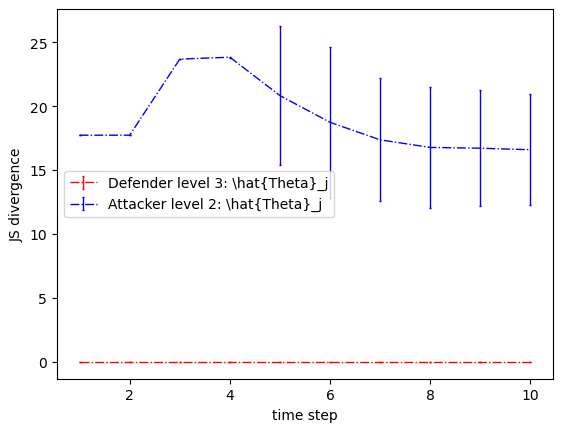

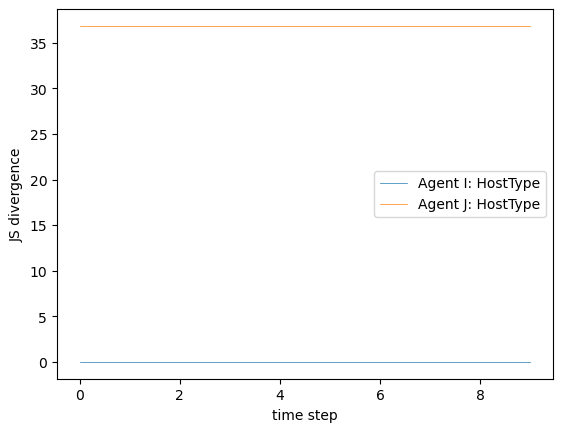

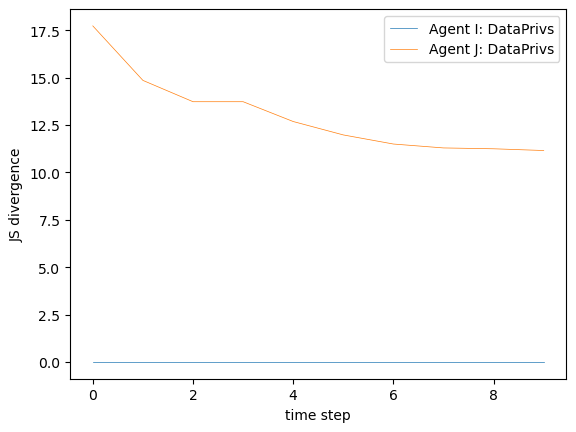

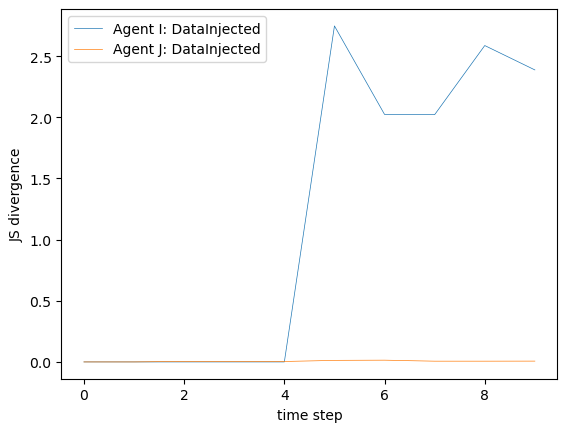

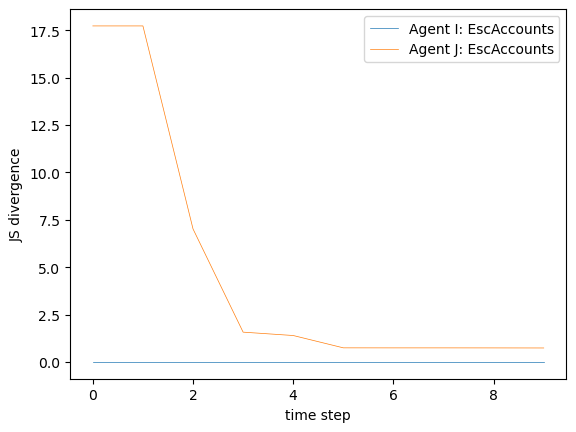

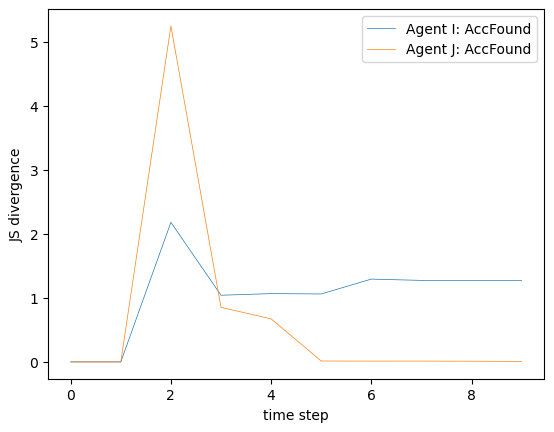

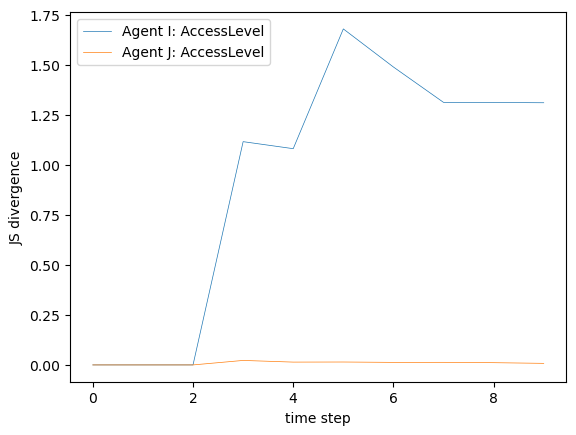

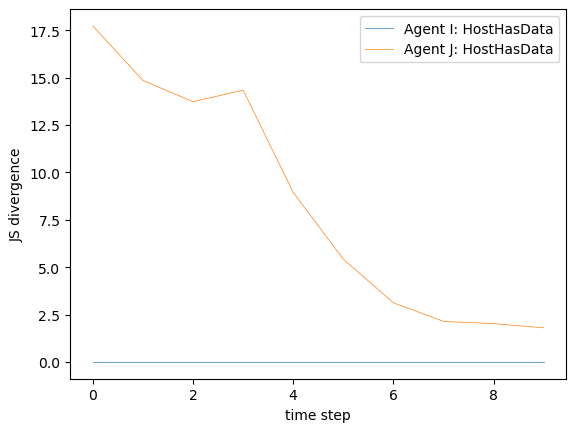

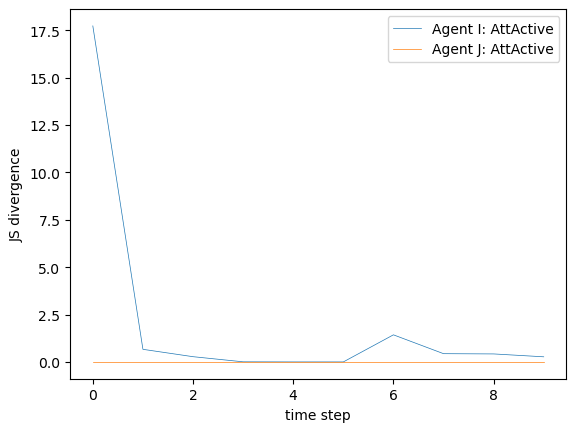

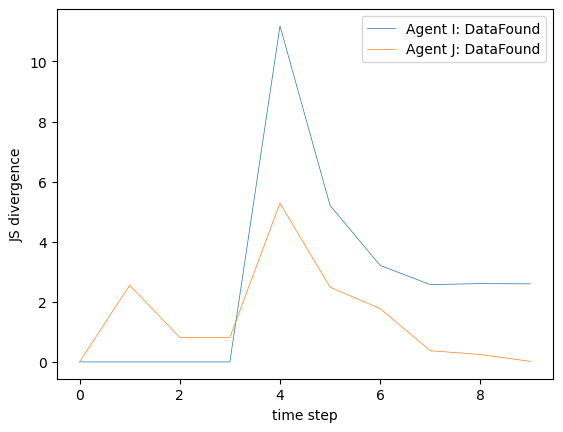

In [6]:
CONTROL_DATA_DIR = Path("/home/ashinde/PhD/CaffineBravery/results/results_l3_fae/")
CONTROL_DATA_FILES = list(CONTROL_DATA_DIR.iterdir())
CONTROL_TRACE_FILES = get_trace_files(CONTROL_DATA_FILES)

state_dict, agent_i_dict, agent_j_dict = get_belief_data(CONTROL_TRACE_FILES)
i_frame_belief, j_frame_belief = get_frame_data(CONTROL_TRACE_FILES)
cross_entropies = get_cross_entropies(state_dict, agent_i_dict, agent_j_dict)

# Plot cross entropies over \hat{Theta}_j
AGENT_I_TRUE_FRAME = "highCap"
AGENT_J_TRUE_FRAME = "att"

groundtruth_frame_i_index = j_frame_belief[0].index(AGENT_I_TRUE_FRAME)
groundtruth_frame_i = numpy.zeros_like(j_frame_belief[1])
groundtruth_frame_i[:, :, groundtruth_frame_i_index] = 1.0

groundtruth_frame_j_index = i_frame_belief[0].index(AGENT_J_TRUE_FRAME)
groundtruth_frame_j = numpy.zeros_like(i_frame_belief[1])
groundtruth_frame_j[:, :, groundtruth_frame_j_index] = 1.0

diff_i = metric(i_frame_belief[1], groundtruth_frame_j, axis=2)
diff_i_mean = numpy.mean(diff_i, axis=0)
diff_i_std = numpy.std(diff_i, axis=0)

diff_j = metric(j_frame_belief[1], groundtruth_frame_i, axis=2)
diff_j_mean = numpy.mean(diff_j, axis=0)
diff_j_std = numpy.std(diff_j, axis=0)

FAE_ATT_MEANS = diff_j_mean
FAE_ATT_STD = diff_j_std

plotter.errorbar(numpy.linspace(1, diff_i_mean.shape[0], diff_i_mean.shape[0]), diff_i_mean, fmt='r-.', yerr=diff_i_std, linewidth=1.0, label="Defender level 3: \hat{Theta}_j", capsize=0.5)
plotter.errorbar(numpy.linspace(1, diff_j_mean.shape[0], diff_j_mean.shape[0]), diff_j_mean, fmt='b-.', yerr=diff_j_std, linewidth=1.0, label="Attacker level 2: \hat{Theta}_j", capsize=0.5)

plotter.xlabel("time step")
plotter.ylabel("JS divergence")
# plotter.ylim(-0.1, 1.1)
plotter.legend()
plotter.show()


for state in cross_entropies.keys():
    agent_i_mean = numpy.mean(cross_entropies[state][0], axis=0)
    agent_j_mean = numpy.mean(cross_entropies[state][1], axis=0)
    plotter.plot(agent_i_mean, label=f"Agent I: {state}", linewidth=0.5)
    plotter.plot(agent_j_mean, label=f"Agent J: {state}", linewidth=0.5)
    plotter.xlabel("time step")
    plotter.ylabel("JS divergence")
    # plotter.ylim(-0.1, 1.1)
    plotter.legend()
    plotter.show()


# For FAE with confirmation bias

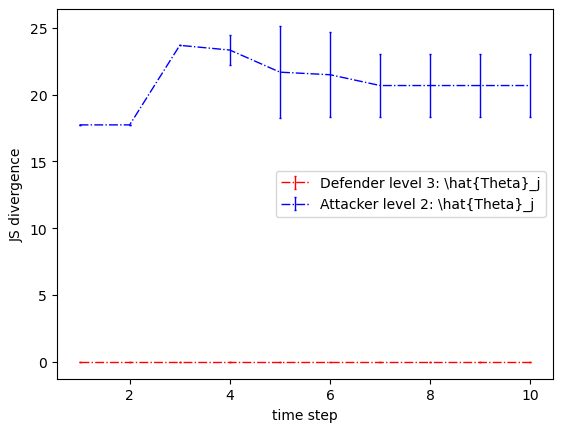

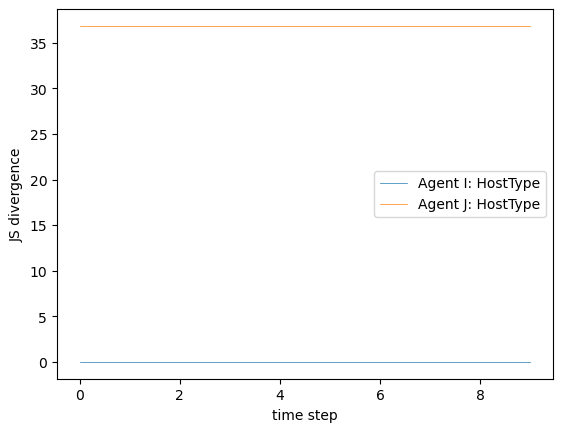

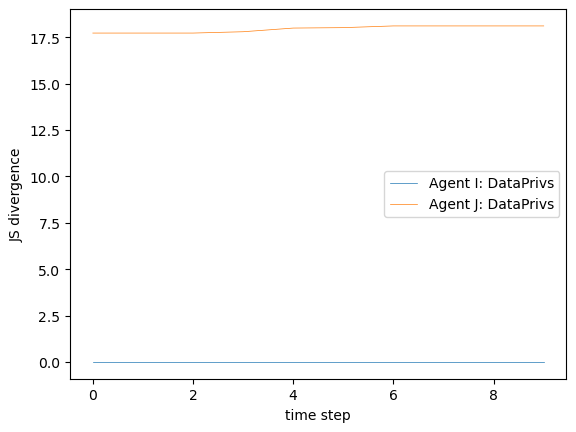

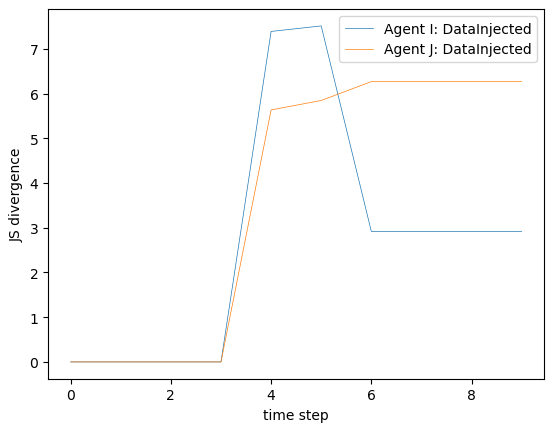

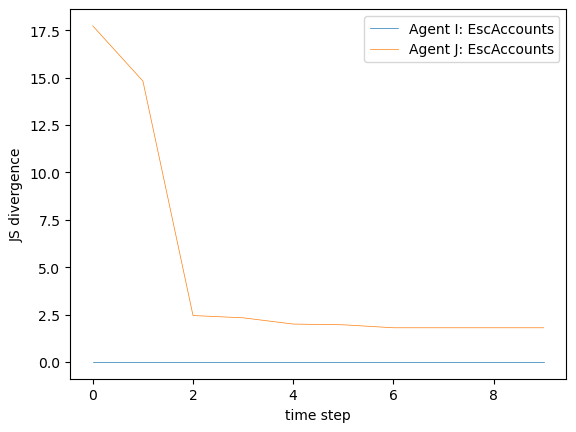

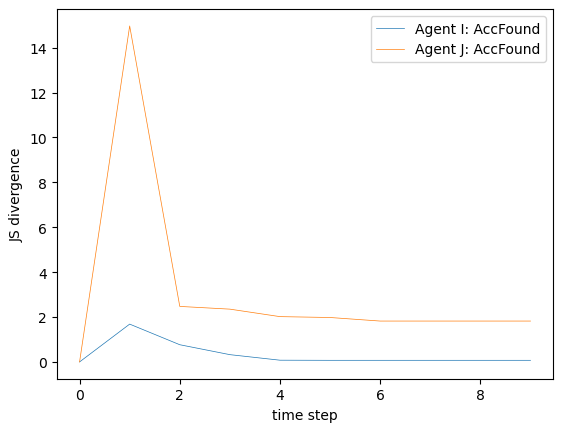

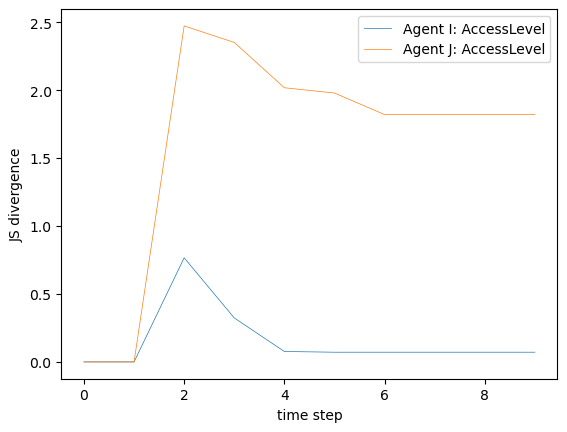

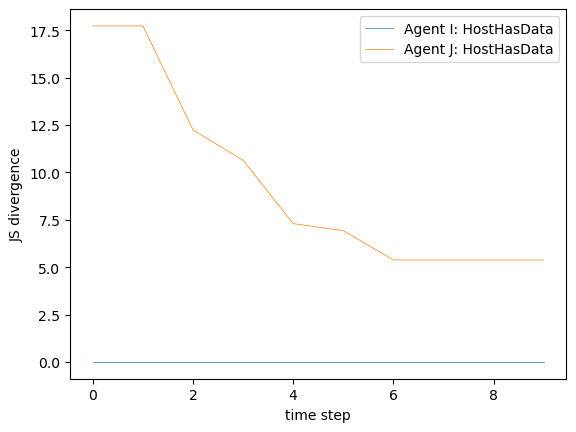

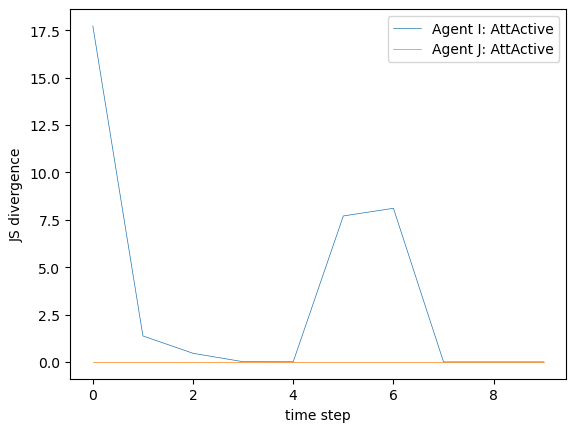

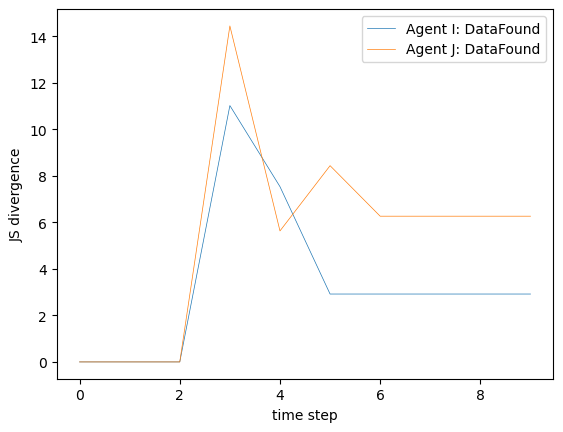

In [7]:
CONTROL_DATA_DIR = Path("/home/ashinde/PhD/CaffineBravery/results/results_l3_fae_biased/")
CONTROL_DATA_FILES = list(CONTROL_DATA_DIR.iterdir())
CONTROL_TRACE_FILES = get_trace_files(CONTROL_DATA_FILES)

state_dict, agent_i_dict, agent_j_dict = get_belief_data(CONTROL_TRACE_FILES)
i_frame_belief, j_frame_belief = get_frame_data(CONTROL_TRACE_FILES)
cross_entropies = get_cross_entropies(state_dict, agent_i_dict, agent_j_dict)

# Plot cross entropies over \hat{Theta}_j
AGENT_I_TRUE_FRAME = "highCap"
AGENT_J_TRUE_FRAME = "att"

groundtruth_frame_i_index = j_frame_belief[0].index(AGENT_I_TRUE_FRAME)
groundtruth_frame_i = numpy.zeros_like(j_frame_belief[1])
groundtruth_frame_i[:, :, groundtruth_frame_i_index] = 1.0

groundtruth_frame_j_index = i_frame_belief[0].index(AGENT_J_TRUE_FRAME)
groundtruth_frame_j = numpy.zeros_like(i_frame_belief[1])
groundtruth_frame_j[:, :, groundtruth_frame_j_index] = 1.0

diff_i = metric(i_frame_belief[1], groundtruth_frame_j, axis=2)
diff_i_mean = numpy.mean(diff_i, axis=0)
diff_i_std = numpy.std(diff_i, axis=0)

diff_j = metric(j_frame_belief[1], groundtruth_frame_i, axis=2)
diff_j_mean = numpy.mean(diff_j, axis=0)
diff_j_std = numpy.std(diff_j, axis=0)

FAE_WITH_CB_MEANS = diff_j_mean
FAE_WITH_CB_STD = diff_j_std

plotter.errorbar(numpy.linspace(1, diff_i_mean.shape[0], diff_i_mean.shape[0]), diff_i_mean, fmt='r-.', yerr=diff_i_std, linewidth=1.0, label="Defender level 3: \hat{Theta}_j", capsize=0.5)
plotter.errorbar(numpy.linspace(1, diff_j_mean.shape[0], diff_j_mean.shape[0]), diff_j_mean, fmt='b-.', yerr=diff_j_std, linewidth=1.0, label="Attacker level 2: \hat{Theta}_j", capsize=0.5)

plotter.xlabel("time step")
plotter.ylabel("JS divergence")
# plotter.ylim(-0.1, 1.1)
plotter.legend()
plotter.show()


for state in cross_entropies.keys():
    agent_i_mean = numpy.mean(cross_entropies[state][0], axis=0)
    agent_j_mean = numpy.mean(cross_entropies[state][1], axis=0)
    plotter.plot(agent_i_mean, label=f"Agent I: {state}", linewidth=0.5)
    plotter.plot(agent_j_mean, label=f"Agent J: {state}", linewidth=0.5)
    plotter.xlabel("time step")
    plotter.ylabel("JS divergence")
    # plotter.ylim(-0.1, 1.1)
    plotter.legend()
    plotter.show()


# Comparative stuff

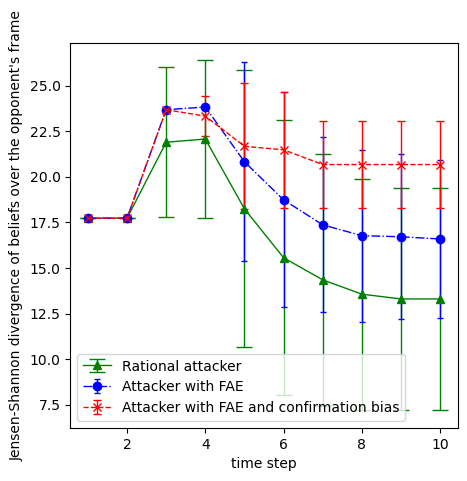

In [8]:
fig = plotter.figure(figsize=(5.0, 5.0))
plotter.errorbar(numpy.linspace(1, RATIONAL_ATT_MEANS.shape[0], RATIONAL_ATT_MEANS.shape[0]), 
                 RATIONAL_ATT_MEANS, fmt='g-^', yerr=RATIONAL_ATT_STD, linewidth=1.0, label="Rational attacker", capsize=6.0)
plotter.errorbar(numpy.linspace(1, RATIONAL_ATT_MEANS.shape[0], RATIONAL_ATT_MEANS.shape[0]), 
                 FAE_ATT_MEANS, fmt='b-.o', yerr=FAE_ATT_STD, linewidth=1.0, label="Attacker with FAE", capsize=2.0)
plotter.errorbar(numpy.linspace(1, RATIONAL_ATT_MEANS.shape[0], RATIONAL_ATT_MEANS.shape[0]), 
                 FAE_WITH_CB_MEANS, fmt='r--x', yerr=FAE_WITH_CB_STD, linewidth=1.0, label="Attacker with FAE and confirmation bias", capsize=3.0)


plotter.xlabel("time step")
plotter.ylabel("KL divergence of beliefs over the opponent's frame")
# plotter.ylim(-0.1, 1.1)
plotter.legend()
plotter.savefig("results.pdf")
plotter.show()

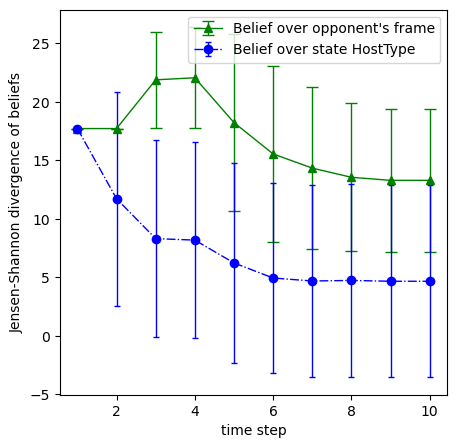

In [9]:
fig = plotter.figure(figsize=(5.0, 5.0))
plotter.errorbar(numpy.linspace(1, RATIONAL_ATT_MEANS.shape[0], RATIONAL_ATT_MEANS.shape[0]), 
                 RATIONAL_ATT_MEANS, fmt='g-^', yerr=RATIONAL_ATT_STD, linewidth=1.0, label="Belief over opponent's frame", capsize=4.0)
plotter.errorbar(numpy.linspace(1, RATIONAL_ATT_MEANS.shape[0], RATIONAL_ATT_MEANS.shape[0]), 
                 STATE_MEANS, fmt='b-.o', yerr=STATE_STD, linewidth=1.0, label="Belief over state HostType", capsize=2.0)

plotter.xlabel("time step")
plotter.ylabel("KL divergence of beliefs")
# plotter.ylim(-0.1, 1.1)
plotter.legend()
plotter.savefig("results_state.pdf")
plotter.show()